In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
df=pd.read_csv('train.csv')
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [5]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [6]:
df.shape

(9800, 18)

In [8]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [9]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

In [10]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object

In [13]:
df['State'].nunique()

49

In [14]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['Postal Code'].fillna(df['Postal Code'].mode()[0],inplace=True)

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

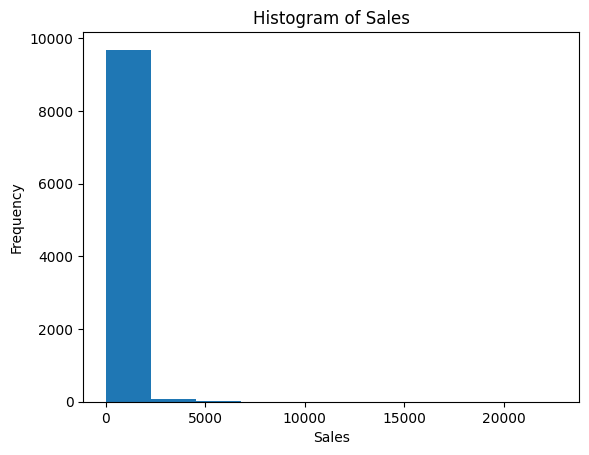

In [24]:
plt.hist(df['Sales'])
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Sales')
plt.show()

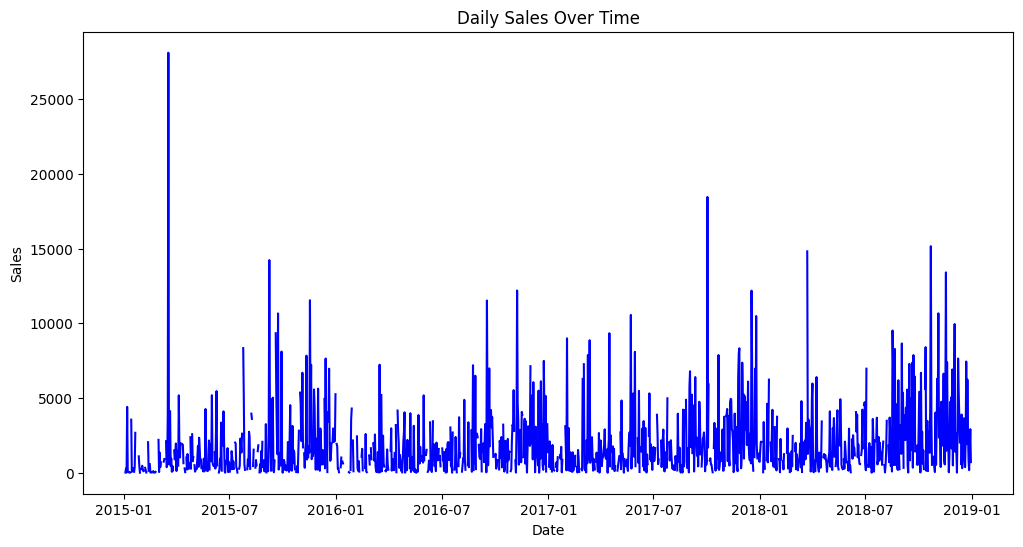


Next 7 Days Sales Forecast:
 2018-12-31    1613.275778
2019-01-01    1281.913421
2019-01-02    1310.599948
2019-01-03    1535.189952
2019-01-04    1683.341279
2019-01-05    1313.768407
2019-01-06    1473.241683
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.set_index('Order Date', inplace=True)
daily_sales = daily_sales.asfreq('D')   
plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales['Sales'])
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()
model = ARIMA(daily_sales['Sales'], order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=7)
print("\nNext 7 Days Sales Forecast:\n", forecast)


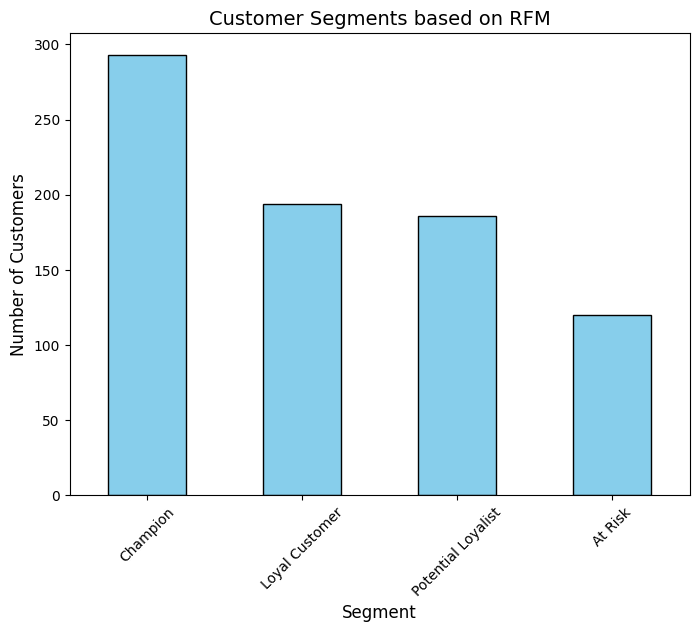

In [39]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d/%m/%Y")
ref_date = df["Order Date"].max() + pd.Timedelta(days=1)
rfm = df.groupby("Customer ID").agg({
    "Order Date": lambda x: (ref_date - x.max()).days,  
    "Order ID": "nunique",                             
    "Sales": "sum"                                 
}).reset_index()
rfm.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]
rfm["R_Segment"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Segment"] = pd.qcut(rfm["Frequency"], 4, labels=[1,2,3,4])
rfm["M_Segment"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])
rfm["RFM_Score"] = rfm[["R_Segment","F_Segment","M_Segment"]].astype(int).sum(axis=1)
def label_rfm(score):
    if score >= 9:
        return "Champion"
    elif score >= 7:
        return "Loyal Customer"
    elif score >= 5:
        return "Potential Loyalist"
    elif score >= 3:
        return "At Risk"
    else:
        return "Lost"
rfm["Segment"] = rfm["RFM_Score"].apply(label_rfm)
segment_counts = rfm["Segment"].value_counts()
plt.figure(figsize=(8,6))
segment_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Customer Segments based on RFM", fontsize=14)
plt.xlabel("Segment", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=45)
plt.show()

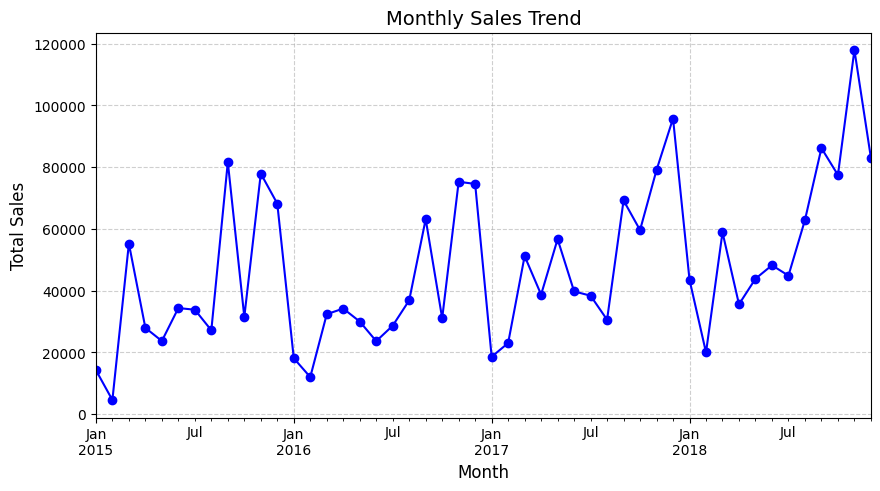

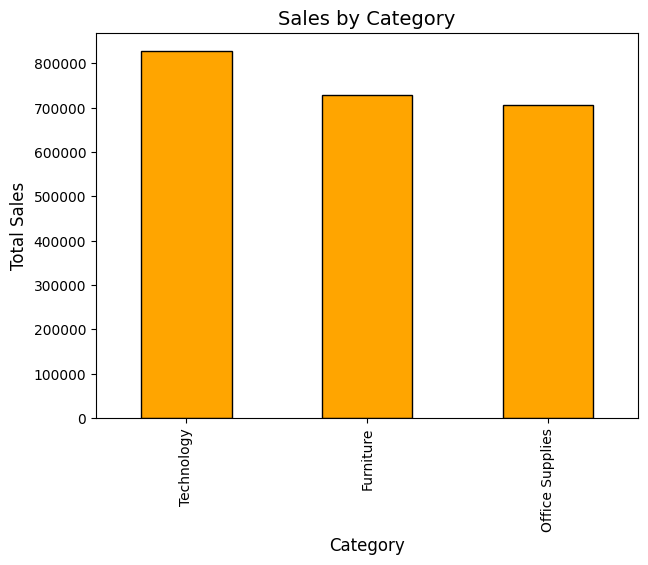

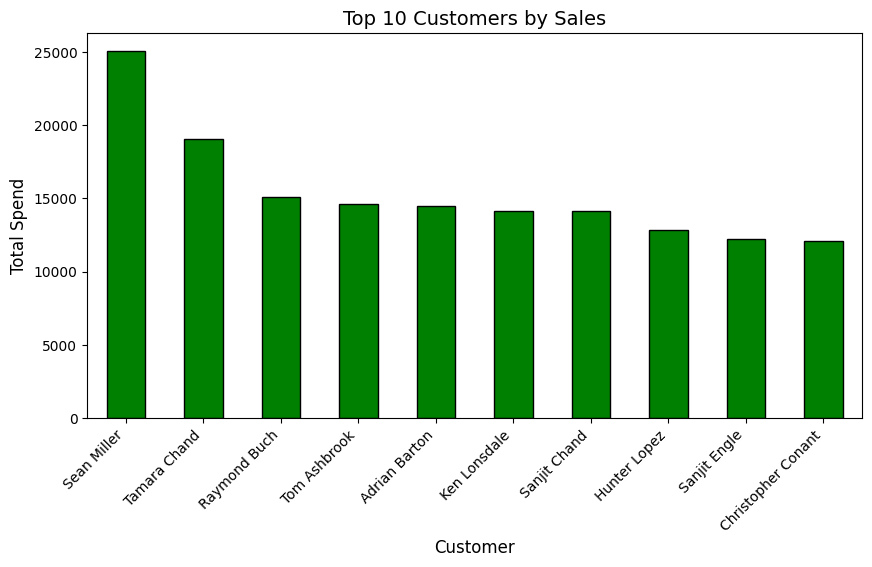

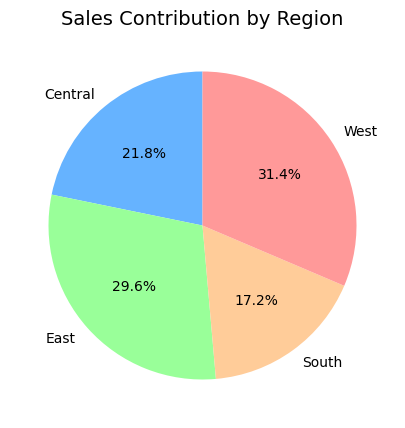

In [ ]:
monthly_sales = df.groupby(df["Order Date"].dt.to_period("M"))["Sales"].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot(kind="line", marker="o", color="blue")
plt.title("Monthly Sales Trend", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
category_sales = df.groupby("Category")["Sales"].sum().sort_values(ascending=False)
plt.figure(figsize=(7,5))
category_sales.plot(kind="bar", color="orange", edgecolor="black")
plt.title("Sales by Category", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.show()
top_customers = df.groupby("Customer Name")["Sales"].sum().nlargest(10)
plt.figure(figsize=(10,5))
top_customers.plot(kind="bar", color="green", edgecolor="black")
plt.title("Top 10 Customers by Sales", fontsize=14)
plt.xlabel("Customer", fontsize=12)
plt.ylabel("Total Spend", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()
region_sales = df.groupby("Region")["Sales"].sum()
plt.figure(figsize=(7,5))
region_sales.plot(kind="pie", autopct='%1.1f%%', startangle=90, colors=["#66b3ff","#99ff99","#ffcc99","#ff9999"])
plt.title("Sales Contribution by Region", fontsize=14)
plt.ylabel("")
plt.show()
